# Variational Logistic Regression


Let $\mathcal{D} = \{({\bf x}_n, t_n) | {\bf x}_n \in \mathbb{R}^M, t_n \in \{0, 1\}\}_{n=1}^N$ be a database. We want to model the target variable $t$ conditioned on ${\bf x}$ as $t|{\bf x} \sim \text{Blli}\left(\sigma({\bf w}^T{\bf \phi({\bf x})})\right)$.


In the variational framework, we seek to maximize a lower bound on the marginal likelihood given by

$$
    p({\bf t}) = \int \left[\prod_{n=1}^N p(t_n | {\bf w})\right] p({\bf w}) d{\bf w}
$$

This notebook explains why and provides additional information in regards to the implementation of the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)

A lower bound on the joint distribution $p({\bf t}, {\bf w})$ is given by
$$
    p({\bf t}, {\bf w}) = p({\bf t}, {\bf w})p({\bf w}) \geq h({\bf w}, \boldsymbol{\varepsilon})
$$

Where the lower bound $h$ is given by

$$
    h({\bf w}, \boldsymbol{\varepsilon}) = \prod_{n=1}^N \sigma(\varepsilon_n)\exp\left({\bf w}^T{\boldsymbol \phi}_nt_n - ({\bf w}^T{\boldsymbol \phi}_n + \varepsilon_n) / 2 - \lambda(\varepsilon_n)\left([{\bf w}^T{\boldsymbol \phi}_n]^2 - \varepsilon^2\right)\right)
$$

and
$$
    \lambda(\varepsilon) = \frac{1}{2\varepsilon}\left[\sigma(\varepsilon) - \frac{1}{2}\right].
$$

Normalizing the joint distribution $p({\bf t}, {\bf w})$ would allow us to find the **true** posterior distribution $p({\bf w} | {\bf t})$. This, however, is intractable. In order to approximate the true posterior $p({\bf w} | {\bf t})$ **we normalize lower bound** $h$ and find a variational approximation $q({\bf w})$ given by

$$
\color{crimson}{
    q({\bf w}) = \mathcal{N}({\bf w} | {\bf m}_N, {\bf S}_N)
}
$$

With

$$
\begin{aligned}
    {\bf S}_N^{-1} &= {\bf S}_0 + 2 \sum_{n=1}^N \lambda(\varepsilon_n){\boldsymbol \phi}_n{\boldsymbol \phi}_n^T \\
    {\bf m}_N &= {\bf S}_0 {\bf m}_0 + \sum_{n=1}^N {\boldsymbol \phi}_n \left(t_n - \frac{1}{2}\right)
\end{aligned}
$$

> The additional flexibility provided by the variational parameters $\{\varepsilon_n\}_{n=1}^N$ leads an improved accuracy [over the Laplacian method] in the approximation.

## Optimizing the variational parameters $\{\varepsilon_n\}_{n=1}^N$
In order to find the **best** variational lower-bound approximation $\color{crimson}{q({\bf w})}$ possible, we must determine the set $\{\varepsilon_n\}_n$ such that **maximize the lower bound on the marginal likelihood** $p({\bf t})$. Due to the monotonically increasing property of the $\log$ function, we note that the following inequality holds:

$$
    \log p({\bf t}, {\bf w}) \geq \log h({\bf w}, \boldsymbol{\varepsilon})
$$

It follows that 

$$
    \log p({\bf t}) \geq \log \int h({\bf w}, \boldsymbol{\varepsilon}) p({\bf w}) d{\bf w} = \mathcal{L}(\varepsilon)
$$

Thefore, we seek to maximize the lower bound on the log-model-evidence $\mathcal{L}(\varepsilon)$

### The EM Way


1. Choose initial values for ${\boldsymbol \varepsilon}^{(old)}$
2. **E-Step**: Evaluate the variational posterior $q({\bf w} | t, {\boldsymbol \varepsilon}^{(old)})$ (of "latent" variables")
3. **M-Step**: Obtain ${\boldsymbol \varepsilon}^{(new)}$ by updating
$$
    {\boldsymbol \varepsilon}^{(new)} = \arg\max_{{\boldsymbol \varepsilon}} \mathcal{Q}({\boldsymbol \varepsilon}, {\boldsymbol \varepsilon}^{(old)}) = \left({\boldsymbol \phi}_n^T ({\bf S}_n + {\bf m}_N{\bf m}_N^T) {\boldsymbol \phi}_n\right)^{1/2}
$$

4. Check for convergence by evaluating the lower-bound $\mathcal{L}({\boldsymbol \varepsilon}_n)$ given by

$$
    \mathcal{L}({\boldsymbol \varepsilon}_n) = \frac{1}{2}\log\frac{\vert{\bf S}_n\vert}{\vert{\bf S}_0\vert} + \frac{1}{2}{\bf m}_N^T {\bf S}^{-1}_N{\bf m}_N - \frac{1}{2}{\bf m}_0^T {\bf S}^{-1}_0{\bf m}_0 + \sum_{n=1}^N\left(\log\sigma(\varepsilon_n) - \varepsilon_n / 2 + \lambda(\varepsilon_n)\varepsilon_n^2 \right)
$$

## Example

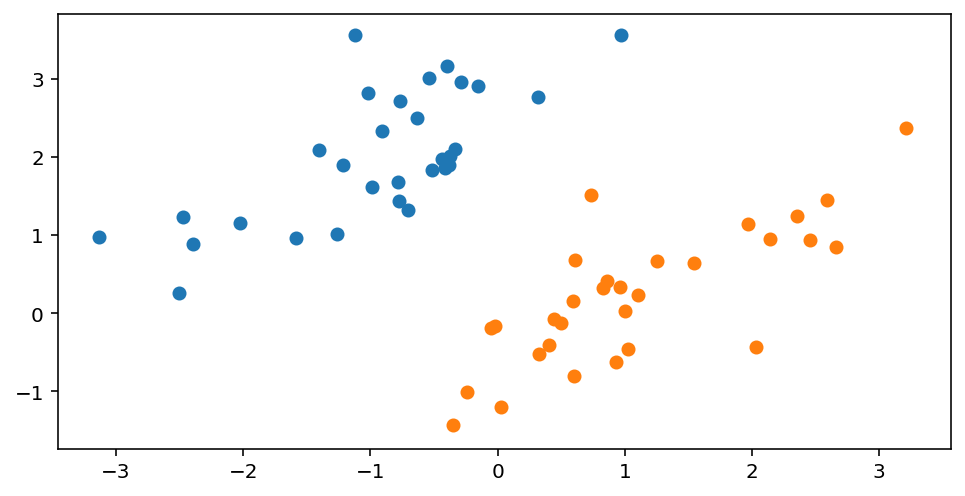

In [47]:
from scipy.stats import multivariate_normal

sigma = 0.2
S = np.array([0.4, 0.1])
S = np.exp(-(S[:, np.newaxis] - S[np.newaxis, :])**2 / (2 * sigma))

N1 = multivariate_normal(mean=[-1, 2], cov=S)
N2 = multivariate_normal(mean=[1, 0], cov=S)

X1 = N1.rvs(size=30, random_state=314)
X2 = N2.rvs(size=30, random_state=3141)
plt.scatter(*X1.T)
plt.scatter(*X2.T);

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lambdaf(eps):
    return (sigmoid(eps) - 1/2) / (2 * eps)

def df(f, x, eps=1e-6):
    return (f(x + eps) - f(x - eps)) / (2 * eps)

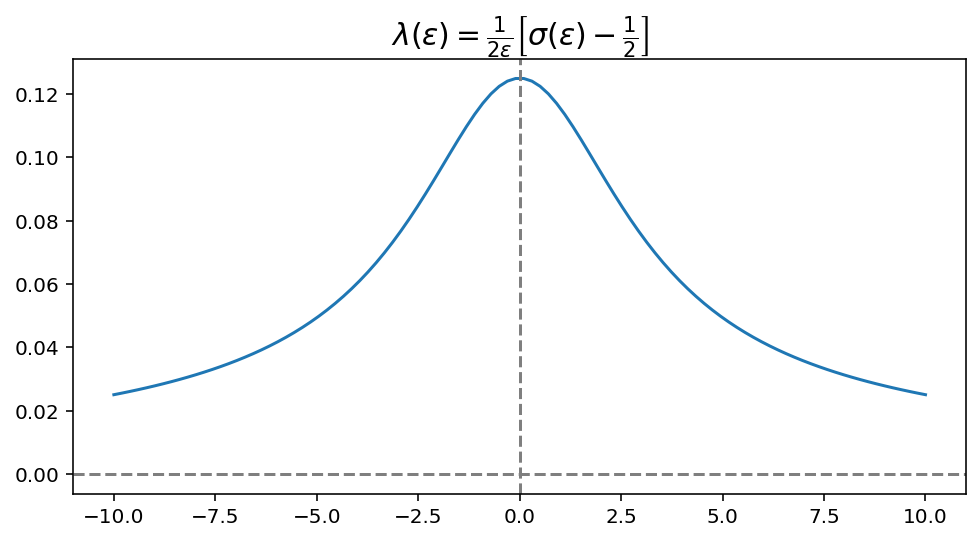

In [45]:
xrange = np.linspace(-10, 10, 100)
plt.plot(xrange, lambdaf(xrange))
eq_title = r"$\lambda(\varepsilon) = \frac{1}{2\varepsilon}\left[\sigma(\varepsilon) - \frac{1}{2}\right]$"
plt.axvline(x=0, c="tab:gray", linestyle="--")
plt.axhline(y=0, c="tab:gray", linestyle="--")
plt.title(eq_title, fontsize=15);

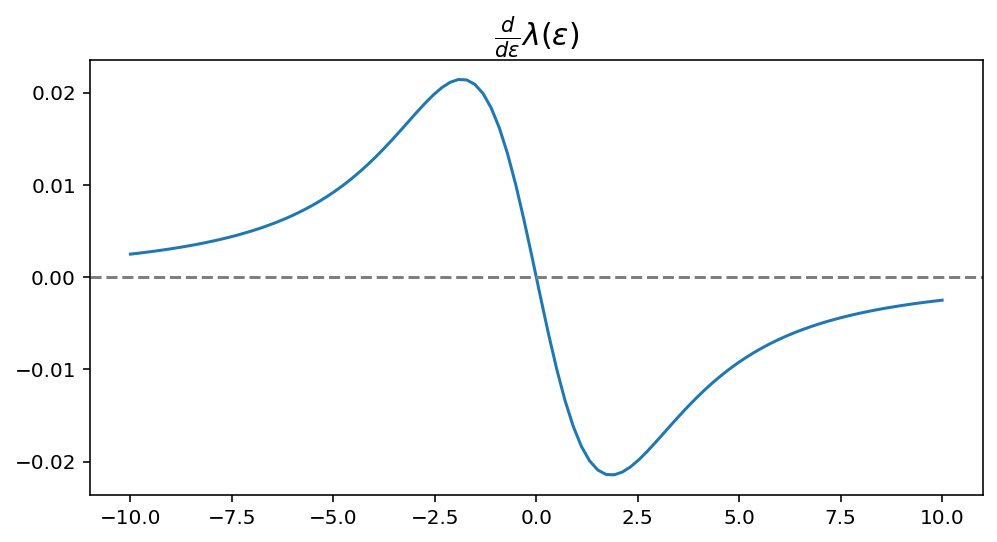

In [59]:
plt.plot(xrange, df(lambdaf, xrange))
eq_title = r"$\frac{d}{d\varepsilon}\lambda(\varepsilon)$"
plt.title(eq_title, fontsize=15)
plt.axhline(y=0, c="tab:gray", linestyle="--");